In [19]:
import scqubits
import qutip
import qutip
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from bidict import bidict

## Define function to convert product index to dressed index

In [4]:
def dressed_state_representation(H_with_interaction_no_drive):
    evals, evecs = H_with_interaction_no_drive.eigenstates() #in the product/LC basis of constituent qubits

    product_state_names = []
    dims = H_with_interaction_no_drive.dims[0]
    system_size = len(dims)

    def generate_product_states(current_state, ele_index):
        if ele_index == system_size:
            product_state_names.append(tuple(current_state))
            return
        
        for l in range(dims[ele_index]):
            current_state[ele_index] = l
            generate_product_states(current_state.copy(), ele_index + 1)

    current_state = [0] * system_size
    generate_product_states(current_state, 0)

    product_states = []
    for name in product_state_names:
        states = [qutip.basis(dims[idx], name[idx]) for idx in range(system_size)]
        product_states.append(qutip.tensor(states))

    dressed_state_representations = []
    for evec in evecs:
        overlaps = [(bra.dag() * evec).data[0, 0] for bra in product_states]
        sorted_indices = np.argsort([abs(overlap) for overlap in overlaps])[::-1]
        total_overlap = 0
        representation = []
        for idx in sorted_indices:
            overlap = overlaps[idx]
            total_overlap += abs(overlap)**2
            sign = "+" if overlap.real >= 0 else "-"
            representation.append((product_state_names[idx], sign,abs(overlap)))
            if total_overlap > 0.9:
                break
        dressed_state_representations.append(representation)

    return dressed_state_representations

def find_corresponding_dressed_eigenstate(molecule_state, osc_state,H_coupled):
    eigenstates_coupled = H_coupled.eigenstates()[1]
    product_state = qutip.tensor(molecule_state, osc_state)

    overlaps = [qutip.metrics.fidelity(eigenstate, product_state) for eigenstate in eigenstates_coupled]

    max_overlap = max(overlaps)
    most_overlapping_index = overlaps.index(max_overlap)
    return most_overlapping_index, max_overlap


In [5]:
# Example usage
evecs = molecule.hamiltonian().eigenstates()[1]
dressed_state_representations = dressed_state_representation(molecule.hamiltonian())
for idx, representation in enumerate(dressed_state_representations):
    print(f"Molecule Eigenstate {idx}:")
    for prod_state, sign, overlap  in representation:
        print(f"  Product state {sign}{prod_state}: {overlap**2 :.2f}")
    # if idx > 5:
    #     break
    molecule_state = evecs[idx]
    for osc_level in [0,1]:
        osc_state = qutip.basis(osc_levels,osc_level)
        most_overlapping_dressed_index, max_overlap = find_corresponding_dressed_eigenstate(molecule_state, osc_state,hilbertspace.hamiltonian())
        print(f"together with oscillator state {osc_level} becomes eigenstate {most_overlapping_dressed_index} \n in dressed system with overlap {max_overlap:.2f}")


Molecule Eigenstate 0:
  Product state +(0, 0): 0.89
  Product state +(1, 1): 0.11
together with oscillator state 0 becomes eigenstate 0 
 in dressed system with overlap 1.00
together with oscillator state 1 becomes eigenstate 18 
 in dressed system with overlap 1.00
Molecule Eigenstate 1:
  Product state -(0, 1): 0.50
  Product state -(1, 0): 0.50
together with oscillator state 0 becomes eigenstate 1 
 in dressed system with overlap 1.00
together with oscillator state 1 becomes eigenstate 20 
 in dressed system with overlap 1.00
Molecule Eigenstate 2:
  Product state -(1, 0): 0.50
  Product state +(0, 1): 0.50
together with oscillator state 0 becomes eigenstate 2 
 in dressed system with overlap 1.00
together with oscillator state 1 becomes eigenstate 21 
 in dressed system with overlap 1.00
Molecule Eigenstate 3:
  Product state -(1, 1): 0.87
  Product state +(0, 0): 0.11
together with oscillator state 0 becomes eigenstate 3 
 in dressed system with overlap 1.00
together with oscilla

# define function to sweep oscillator frequency

In [15]:
def dressed_transition_frequency_over_2pi(hilbertspace,s0: int, s1: int) -> float:
    return abs(hilbertspace.energy_by_dressed_index(s1) - hilbertspace.energy_by_dressed_index(s0))
def replace_non_float64_with_none(lst):
    for i in range(len(lst)):
        if type(lst[i]) is not np.float64:
            lst[i] = None
    return lst
def sweep_resonator_frequency_for_detunning(EJ = 4,
                                        EC =1,
                                        EL = 1,
                                        molecule_coupling = 0.001,
                                        g = 0.3,
                                        assymetry = 0.003):
    flux_1 = (2+assymetry)/2*flux_ext
    flux_2 = (2-assymetry)/2*flux_ext

    qubit_levels = 5
    osc_levels = 3
                                    
    E_vals = np.linspace(1, 10, 100)
    g0g1_vals = []
    e0e1_vals = []
    f0f1_vals = []
    h0h1_vals = []

    qubit1 = scqubits.Fluxonium(EJ = EJ,
                        EC =EC,
                        EL = EL,
                        flux = flux_1,
                        cutoff = 110,
                        truncated_dim = qubit_levels)
    qubit2 = scqubits.Fluxonium(EJ = EJ,
                        EC =EC,
                        EL = EL,
                        flux = flux_2,
                        cutoff = 110,
                        truncated_dim = qubit_levels)

    molecule = scqubits.HilbertSpace([qubit1,qubit2])
    molecule.add_interaction(
        g_strength=molecule_coupling, op1=qubit1.phi_operator, op2=qubit2.phi_operator, add_hc=False
    )
    molecule.generate_lookup()
    name_to_molecule_level = {'g':0,'e':1,'f':2,'h':3}
    molecule_evecs = molecule.hamiltonian().eigenstates()[1]

    num_done = 0
    num_tot = len(E_vals)
    for e in E_vals:
        osc = scqubits.Oscillator(
            E_osc=e,
            truncated_dim=3
        )
        hilbertspace = scqubits.HilbertSpace([qubit1,qubit2, osc])

        hilbertspace.add_interaction(
            g_strength=molecule_coupling, op1=qubit1.phi_operator, op2=qubit2.phi_operator, add_hc=False
        )
        hilbertspace.add_interaction(
            g_strength=g, op1=qubit1.n_operator, op2=osc.creation_operator, add_hc=True
        )

        hilbertspace.add_interaction(
            g_strength=g, op1=qubit2.n_operator, op2=osc.creation_operator, add_hc=True
        )

        hilbertspace.generate_lookup()
        name_to_dressed_level = {}
        for ml_name, ml in name_to_molecule_level.items():
            name_to_dressed_level[ml_name] = (
                find_corresponding_dressed_eigenstate(molecule_evecs[ml], qutip.basis(osc_levels,0),hilbertspace.hamiltonian())[0],
                find_corresponding_dressed_eigenstate(molecule_evecs[ml], qutip.basis(osc_levels,1),hilbertspace.hamiltonian())[0]
            )

        g0g1 = dressed_transition_frequency_over_2pi(hilbertspace,name_to_dressed_level['g'][0],name_to_dressed_level['g'][1])
        e0e1 = dressed_transition_frequency_over_2pi(hilbertspace,name_to_dressed_level['e'][0],name_to_dressed_level['e'][1])
        f0f1 = dressed_transition_frequency_over_2pi(hilbertspace,name_to_dressed_level['f'][0],name_to_dressed_level['f'][1])
        h0h1 = dressed_transition_frequency_over_2pi(hilbertspace,name_to_dressed_level['h'][0],name_to_dressed_level['h'][1])

        g0g1_vals.append(g0g1)
        e0e1_vals.append(e0e1)
        f0f1_vals.append(f0f1)
        h0h1_vals.append(h0h1)
        g0g1_vals = replace_non_float64_with_none(g0g1_vals)
        e0e1_vals = replace_non_float64_with_none(e0e1_vals)
        f0f1_vals = replace_non_float64_with_none(f0f1_vals)
        h0h1_vals = replace_non_float64_with_none(h0h1_vals)

        num_done += 1
        if num_done %10 == 0:
            clear_output()
            print(f'done: {num_done}/{num_tot}')

    chi_eg_MHz = []
    for a, b in zip(g0g1_vals,e0e1_vals):
        if a is None or b is None:
            chi_eg_MHz.append(None)
        else:
            chi_eg_MHz.append((a - b)/2*1000)
    chi_ef_MHz = []
    for a, b in zip(f0f1_vals, e0e1_vals):
        if a is None or b is None:
            chi_ef_MHz.append(None)
        else:
            chi_ef_MHz.append((a - b)/2*1000)
    chi_he_MHz = []
    for a, b in zip(e0e1_vals,h0h1_vals):
        if a is None or b is None:
            chi_he_MHz.append(None)
        else:
            chi_he_MHz.append((a - b)/2*1000)

    plt.plot(E_vals, chi_eg_MHz, label=r'$\chi_{\mathrm{eg}}$')
    plt.plot(E_vals, chi_ef_MHz, label=r'$\chi_{\mathrm{ef}}$')
    plt.plot(E_vals, chi_he_MHz, label=r'$\chi_{\mathrm{he}}$')

    plt.legend()
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    plt.xlabel("resonator frequency (GHz)")
    plt.ylabel("detunning (MHz)  relevant for erasure and computational measurement")
    plt.show()

done: 100/100


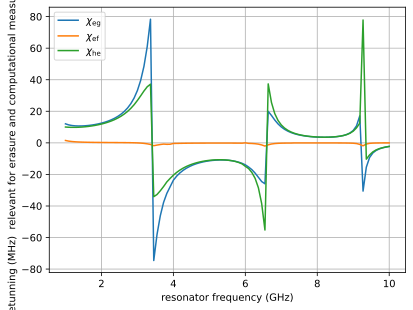

In [16]:
sweep_resonator_frequency_for_detunning(EJ = 4,
                                        EC =1,
                                        EL = 1,
                                        molecule_coupling = 0.001,
                                        g = 0.3,
                                        assymetry = 0.003)


done: 100/100


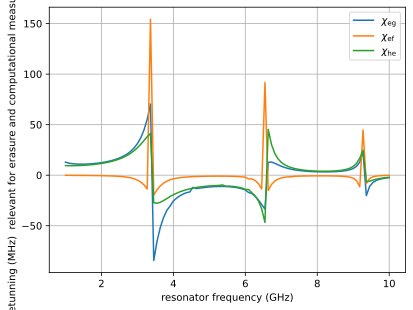

In [17]:
sweep_resonator_frequency_for_detunning(EJ = 4,
                                        EC =1,
                                        EL = 1,
                                        molecule_coupling = 0.01,
                                        g = 0.3,
                                        assymetry = 0.003)


# Create molecule and osc instance

In [42]:
EJ = 4
EC = 1
EL = 1
molecule_coupling = 0.001
flux_ext = 0.5
g = 0.3
assymetry = 0.003
flux_1 = (2+assymetry)/2*flux_ext
flux_2 = (2-assymetry)/2*flux_ext

qubit_levels = 5
osc_levels = 3
osc_frequency = 5

qubit1 = scqubits.Fluxonium(EJ = EJ,
                    EC =EC,
                    EL = EL,
                    flux = flux_1,
                    cutoff = 110,
                    truncated_dim = qubit_levels)
qubit2 = scqubits.Fluxonium(EJ = EJ,
                    EC =EC,
                    EL = EL,
                    flux = flux_2,
                    cutoff = 110,
                    truncated_dim = qubit_levels)

osc = scqubits.Oscillator(
    E_osc = osc_frequency,
    l_osc = 1,
    truncated_dim=osc_levels
)

hilbertspace = scqubits.HilbertSpace([qubit1,qubit2, osc])
hilbertspace.add_interaction(
    g_strength=molecule_coupling, op1=qubit1.phi_operator, op2=qubit2.phi_operator, add_hc=False
)
hilbertspace.add_interaction(
    g_strength=g, op1=qubit1.n_operator, op2=osc.creation_operator, add_hc=True
)
hilbertspace.add_interaction(
    g_strength=g, op1=qubit2.n_operator, op2=osc.creation_operator, add_hc=True
)
hilbertspace.generate_lookup()

# Plot oscillator-dressed levels

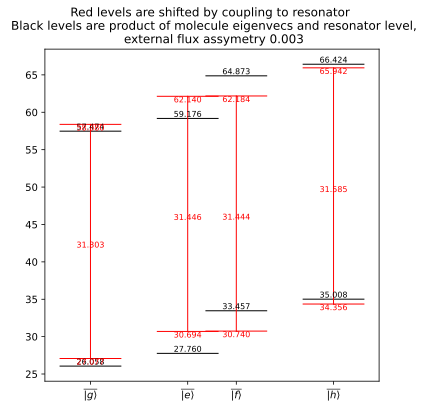

In [43]:
# 1 manually enter dressed state name -> molecule level, dressed levels, and x localtion
name_to_molecule_level = {'g':0,'e':1,'f':2,'h':3}
name_to_dressed_level = {}
molecule_evecs = molecule.hamiltonian().eigenstates()[1]

for ml_name, ml in name_to_molecule_level.items():
    name_to_dressed_level[ml_name] = (
        find_corresponding_dressed_eigenstate(molecule_evecs[ml], qutip.basis(osc_levels,0),hilbertspace.hamiltonian())[0],
        find_corresponding_dressed_eigenstate(molecule_evecs[ml], qutip.basis(osc_levels,1),hilbertspace.hamiltonian())[0]
    )
name_to_x_loc = {'g':-1,'e':-0.2,'f':0.2,'h':1}


bare_color = 'black'
dressed_color = 'red'
energy_text_size = 8

molecule_evals = molecule.hamiltonian().eigenenergies()
hilbertspace_evals = hilbertspace.hamiltonian().eigenenergies()
max_resonator_level = 2
osc_evals = osc.eigenvals(max_resonator_level)


fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
for name, x_loc in name_to_x_loc.items():
    x1,x2 = x_loc-0.25,x_loc+0.25
    dressed_energies = []
    for rl in range(0,max_resonator_level):
        # 1 plot molecule + osc bare levels 
        molecule_eval = molecule_evals[name_to_molecule_level[name]]
        osc_eval = osc_evals[rl]
        original = (molecule_eval + osc_eval)* 2 * np.pi
        
        ax.plot([x1, x2], [original, original], linewidth=1, color=bare_color)
        ax.text(x_loc, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom',color=bare_color)

        # 2 plot molecule + osc dressed levels 
        dressed_index = name_to_dressed_level[name][rl]
        dressed_energy = hilbertspace_evals[dressed_index]* 2 * np.pi
        dressed_energies.append(dressed_energy)
        ax.plot([x1, x2], [dressed_energy, dressed_energy], linewidth=1, color=dressed_color)
        ax.text(x_loc, dressed_energy, f"{dressed_energy:.3f}", fontsize=energy_text_size, ha='center', va='top', color=dressed_color)


    ax.plot([x_loc, x_loc], dressed_energies, linewidth=1, color=dressed_color)
    ax.text(x_loc, (dressed_energies[0]+dressed_energies[1])/2, f"{abs((dressed_energies[0]-dressed_energies[1])):.3f}", fontsize=energy_text_size, ha='center', va='top', color=dressed_color)

x = [x_loc for name, x_loc in name_to_x_loc.items()]
ticks = [r"$\overline{|%s\rangle}$" % str(",".join(name)) for name in ['g','e','f','h']]
plt.xticks(x, ticks)

plt.title(f'Red levels are shifted by coupling to resonator \n Black levels are product of molecule eigenvecs and resonator level,\n external flux assymetry {assymetry}')
plt.show()




# Drive and evolve


In [44]:
a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)

a = qutip.Qobj(a[:, :])# We work in energy eigenbasis, thus not using tensor products

(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
diag_dressed_hamiltonian = qutip.Qobj(diag_dressed_hamiltonian[:, :])

def transition_frequency(s0: int, s1: int) -> float:
    return abs(
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )

dressed_g0_index = find_corresponding_dressed_eigenstate(molecule_evecs[0],qutip.basis(osc_levels,0),hilbertspace.hamiltonian())[0]
dressed_g1_index = find_corresponding_dressed_eigenstate(molecule_evecs[0],qutip.basis(osc_levels,1),hilbertspace.hamiltonian())[0]
dressed_h0_index = find_corresponding_dressed_eigenstate(molecule_evecs[3],qutip.basis(osc_levels,0),hilbertspace.hamiltonian())[0]
dressed_h1_index = find_corresponding_dressed_eigenstate(molecule_evecs[3],qutip.basis(osc_levels,1),hilbertspace.hamiltonian())[0]

w_d1 = transition_frequency(dressed_g0_index,dressed_g1_index)
w_d2 = transition_frequency(dressed_h0_index,dressed_h1_index)

tot_time = 100
matrix_element_driven_1 = abs((a+a.dag()).data.toarray()[dressed_g0_index][dressed_g1_index])
matrix_element_driven_2 = abs((a+a.dag()).data.toarray()[dressed_h0_index][dressed_h1_index])

A_square_1 = 1/tot_time
A_square_1 = A_square_1/matrix_element_driven_1
A_square_2 = 1/tot_time
A_square_2 = A_square_2/matrix_element_driven_2

# tot_time = int(tot_time*2)
tlist = np.linspace(0, tot_time, tot_time*2)
def square_cos(t,*args):
    cos1 = np.cos(w_d1 * 2*np.pi * t)
    cos2 = np.cos(w_d2 * 2*np.pi * t)
    return  2*np.pi *A_square_1 * cos1 + 2*np.pi *A_square_2 * cos2

H_with_drive = [
    diag_dressed_hamiltonian,
    [a+a.dag(), square_cos]]


product_states = [('g', 0),('g', 1), ('e', 0), ('e', 1),  ('f', 0),  ('f', 1), ('h', 0 ), ('h',1)]
dressed_idxs = [name_to_dressed_level[name[0]][name[1]] for name in product_states]
qutip_states = [qutip.basis(hilbertspace.dimension, idx) for idx in dressed_idxs]

results = []
for dressed_idx in [name_to_dressed_level[name[0]][name[1]] for name in   [('g', 0),('e', 0), ('f', 0), ('h', 0 )]]:
    temp = qutip.mesolve(
        H = H_with_drive,
        rho0 = qutip.basis(hilbertspace.dimension, dressed_idx),
        tlist = tlist,
        e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                               a.dag()*a],
        options=qutip.Options(store_states=True,nsteps=1000),
        progress_bar =True
    )
    results.append(temp)

10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.32s. Est. time left: 00:00:00:01
30.0%. Run time:   0.50s. Est. time left: 00:00:00:01
40.0%. Run time:   0.67s. Est. time left: 00:00:00:01
50.0%. Run time:   0.85s. Est. time left: 00:00:00:00
60.0%. Run time:   1.03s. Est. time left: 00:00:00:00
70.0%. Run time:   1.21s. Est. time left: 00:00:00:00
80.0%. Run time:   1.38s. Est. time left: 00:00:00:00
90.0%. Run time:   1.56s. Est. time left: 00:00:00:00
Total run time:   1.73s
10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.34s. Est. time left: 00:00:00:01
30.0%. Run time:   0.53s. Est. time left: 00:00:00:01
40.0%. Run time:   0.72s. Est. time left: 00:00:00:01
50.0%. Run time:   0.93s. Est. time left: 00:00:00:00
60.0%. Run time:   1.12s. Est. time left: 00:00:00:00
70.0%. Run time:   1.33s. Est. time left: 00:00:00:00
80.0%. Run time:   1.53s. Est. time left: 00:00:00:00
90.0%. Run time:   1.73s. Est. time left: 00:00:00:00
Tota

In [45]:
# In case alpha oscillates not at drive frequency 
def find_dominant_frequency(expectation,tlist,dominant_frequency_already_found = None,plot = False):
    if dominant_frequency_already_found != None:
        expectation = expectation * np.exp(-1j*2*np.pi*dominant_frequency_already_found*tlist)

    expectation_fft = np.fft.fft(expectation)
    frequencies = np.fft.fftfreq(len(tlist), d=(tlist[1] - tlist[0]))  # assuming tlist is uniformly spaced

    # Identify the dominant frequency: 
    # (we exclude the zero frequency, which usually has the DC offset)
    dominant_freq_idx = np.argmax(np.abs(expectation_fft[1:])) + 1
    dominant_freq = frequencies[dominant_freq_idx]

    if plot:
        # Print the dominant frequency
        print(f"The dominant oscillation frequency is: {dominant_freq:.3f} (in the same units as 1/timestep)")

        fft_shifted = np.fft.fftshift(expectation_fft)
        frequencies_shifted = np.fft.fftshift(frequencies)
        plt.plot(frequencies_shifted, np.abs(fft_shifted))
        plt.xlabel('Frequency (arbitrary units)')
        plt.ylabel('Magnitude')
        plt.title('FFT of the Expectation Value')
        plt.grid(True)
        plt.show()
    else:
        return dominant_freq

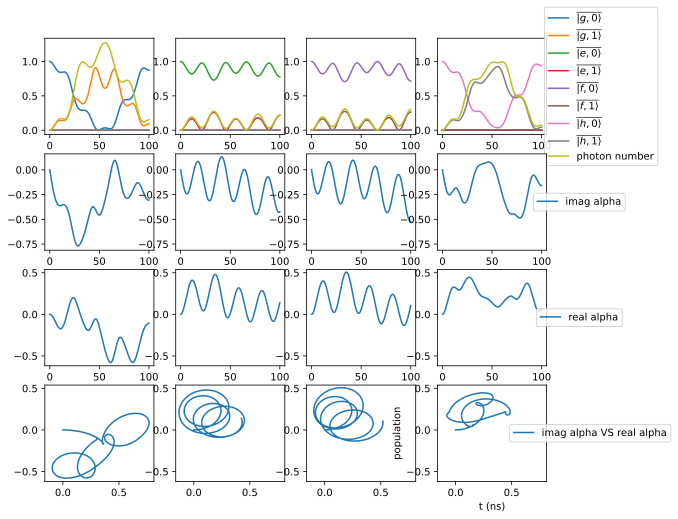

In [46]:
nlevels = len(results)
dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}
fig, axes = plt.subplots(4, len(results), figsize=(9, 2*nlevels))
dominant_freq = [find_dominant_frequency(result.expect[-2],tlist) for result in results]

for i in range(nlevels):
    for idx, res in zip(dressed_idxs, results[i].expect):
        product_state = product_states[dressed_idxs.index(idx)]
        molecule_state = product_state[0]
        resonator_state = str(product_state[1])
        axes[0][i].plot(tlist, res, label=r"$\overline{|%s\rangle}$" % (str(",".join([molecule_state,resonator_state]))))
    
    alpha = results[i].expect[-2]*np.exp(-1j * 2 * np.pi * dominant_freq[i] * tlist)  
    real = alpha.real
    imag = alpha.imag
    axes[0][i].plot(tlist, results[i].expect[-1], label=r"photon number")
    axes[1][i].plot(tlist,imag , label=r"imag alpha")
    axes[2][i].plot(tlist, real, label=r"real alpha")
    axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")

axes[0][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
axes[1][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[2][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[3][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
plt.ylabel("population")
plt.xlabel("t (ns)")
for row in [0,1,2,3]:
    max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
    for col in range(nlevels):
        ymin, ymax = axes[row][col].get_ylim()
        xmin, xmax = axes[row][col].get_xlim()
        if ymax > max_y_range:
            max_y_range = ymax
        if ymin < min_y_range:
            min_y_range = ymin
        if xmax > max_x_range:
            max_x_range = xmax
        if xmin < min_x_range:
            min_x_range = xmin
    for col in range(nlevels):
        axes[row][col].set_ylim(min_y_range, max_y_range)
        axes[row][col].set_xlim(min_x_range,max_x_range)
# plt.yscale('log')
plt.show()